<a href="https://colab.research.google.com/github/JerryEnes/Multimodal-Biometrics/blob/main/Copy_of_Untitled22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All images preprocessed and saved.


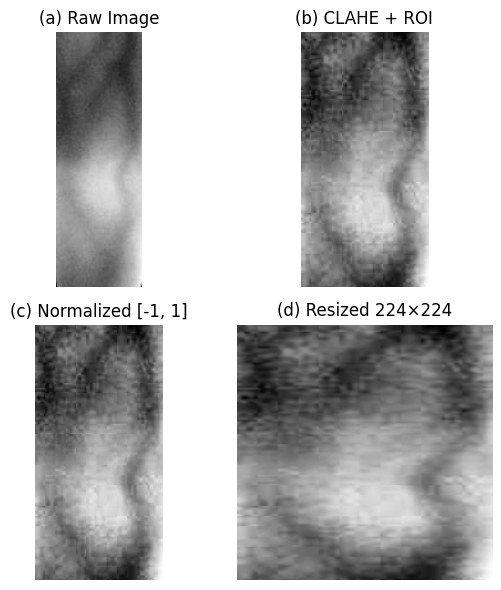

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Input and Output root directories
input_root_dir = '/content/drive/MyDrive/2nd_session-20230913T085108Z-001/2nd_session/extractedvein'        # original nested folders
output_root_dir = '/content/drive/MyDrive/FV Preprocessed' # processed output folders
os.makedirs(output_root_dir, exist_ok=True)

# -------------------------------
# Step 1: Mini-ROI Extraction
def extract_mini_roi(image, roi_size=(100, 200)):
    h, w = image.shape[:2]
    cx, cy = w // 2, h // 2
    x1 = max(cx - roi_size[0] // 2, 0)
    y1 = max(cy - roi_size[1] // 2, 0)
    x2 = min(cx + roi_size[0] // 2, w)
    y2 = min(cy + roi_size[1] // 2, h)
    return image[y1:y2, x1:x2]

# -------------------------------
# ✅ Step 2: Enhanced CLAHE for better vein contrast
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4, 4))  # More aggressive
    return clahe.apply(gray)

# -------------------------------
# Step 3: Normalize [-1, 1]
def normalize_image(image):
    return image.astype(np.float32) / 127.5 - 1.0

# -------------------------------
# Step 4: Resize + Convert to RGB
def preprocess_image(image):
    roi = extract_mini_roi(image)
    clahe_img = apply_clahe(roi)
    norm_img = normalize_image(clahe_img)
    resized_img = cv2.resize(norm_img, (224, 224))
    rgb_img = cv2.cvtColor(((resized_img + 1.0) * 127.5).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    return rgb_img, image, roi, clahe_img, norm_img, resized_img

# -------------------------------
# Traverse and process all images
first_sample = None
for root, _, files in os.walk(input_root_dir):
    for fname in files:
        if not fname.lower().endswith(('.jpg', '.jpeg', '.bmp', '.png')):
            continue

        input_path = os.path.join(root, fname)
        rel_path = os.path.relpath(input_path, input_root_dir)
        output_path = os.path.join(output_root_dir, rel_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        image = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            print(f"❌ Failed to read: {input_path}")
            continue

        processed_img, original, roi, clahe_img, norm_img, resized = preprocess_image(image)
        cv2.imwrite(output_path, processed_img)

        # Save one sample for 2×2 display
        if first_sample is None:
            first_sample = {
                'original': original,
                'roi_clahe': clahe_img,
                'normalized': norm_img,
                'resized': resized
            }

print("✅ All images preprocessed and saved.")

# -------------------------------
# 📊 Visualize one sample in 2x2 grid
if first_sample:
    fig, axs = plt.subplots(2, 2, figsize=(6, 6))

    axs[0, 0].imshow(first_sample['original'], cmap='gray')
    axs[0, 0].set_title('(a) Raw Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(first_sample['roi_clahe'], cmap='gray')
    axs[0, 1].set_title('(b) CLAHE + ROI')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(first_sample['normalized'], cmap='gray')
    axs[1, 0].set_title('(c) Normalized [-1, 1]')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(((first_sample['resized'] + 1.0) * 127.5).astype(np.uint8), cmap='gray')
    axs[1, 1].set_title('(d) Resized 224×224')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()
